Data Genration and Preparation

In [1]:

import pandas as pd
import numpy as np

np.random.seed(42)
num_rows = 2000

education_levels = ['HS-grad', 'Some-college', 'Assoc', 'Bachelors', 'Masters', 'PhD']
occupations = [
    'Software Engineer','Business Analyst','Sales Associate',
    'Data Scientist', 'Project Manager', 'Accountant',
    'Professor', 'Research Scientist', 'Legal Advisor',
    'Marketing Manager', 'Graphic Designer',
    'Quality Analyst', 'Plant Supervisor', 'Nurse',
    'Tech-support', 'Craft-repair', 'Other-service',
    'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical',
    'Farming-fishing', 'Transport-moving', 'Priv-house-serv',
    'Protective-serv', 'Armed-Forces'
]
edu_to_jobs = {
    'HS-grad': [2,9,10],
    'Some-college': list(range(13,25)),
    'Assoc': [11,12,13],
    'Bachelors': [0,1,2],
    'Masters': [3,4,5],
    'PhD': [6,7,8]
}

data = []
for _ in range(num_rows):
    edu = np.random.choice(education_levels)
    occ_idx = np.random.choice(edu_to_jobs[edu])
    occ = occupations[occ_idx]
    age = np.random.randint(18, 66)
    experience = np.random.randint(0, min(age-17, 41))
    hours_per_week = np.random.randint(20, 70)
    base = 20000
    edu_factor = {"HS-grad": 1.0, "Some-college": 1.1, "Assoc": 1.12, "Bachelors": 1.25, "Masters": 1.4, "PhD": 1.6}
    occ_premium = {
        "Software Engineer": 1.5, "Business Analyst": 1.3, "Sales Associate": 1.0,
        "Data Scientist": 1.7, "Project Manager": 1.4, "Accountant": 1.2,
        "Professor": 1.6, "Research Scientist": 1.8, "Legal Advisor": 1.5,
        "Marketing Manager": 1.2, "Graphic Designer": 1.05,
        "Quality Analyst": 1.1, "Plant Supervisor": 1.09, "Nurse": 1.13,
        "Tech-support": 1.0, "Craft-repair": 0.9, "Other-service": 0.85,
        "Handlers-cleaners": 0.82, "Machine-op-inspct": 0.87, "Adm-clerical": 1.0,
        "Farming-fishing": 0.8, "Transport-moving": 0.93, "Priv-house-serv": 0.78,
        "Protective-serv": 1.05, "Armed-Forces": 1.12
    }
    experience_factor = 900 * experience
    hours_factor = (hours_per_week - 40) * 200
    salary = (
        base
        * edu_factor[edu]
        * occ_premium[occ]
        + experience_factor
        + np.maximum(hours_factor, 0)
        + np.random.normal(0, 2500)
    )
    salary = np.clip(salary, 18000, 250000)
    data.append([age, edu, occ, experience, hours_per_week, int(salary)])

df = pd.DataFrame(data, columns=['age','education','occupation','experience','hours-per-week','salary'])
df.to_csv('synthetic_salary_data.csv', index=False)


Model Training and Visuzlation

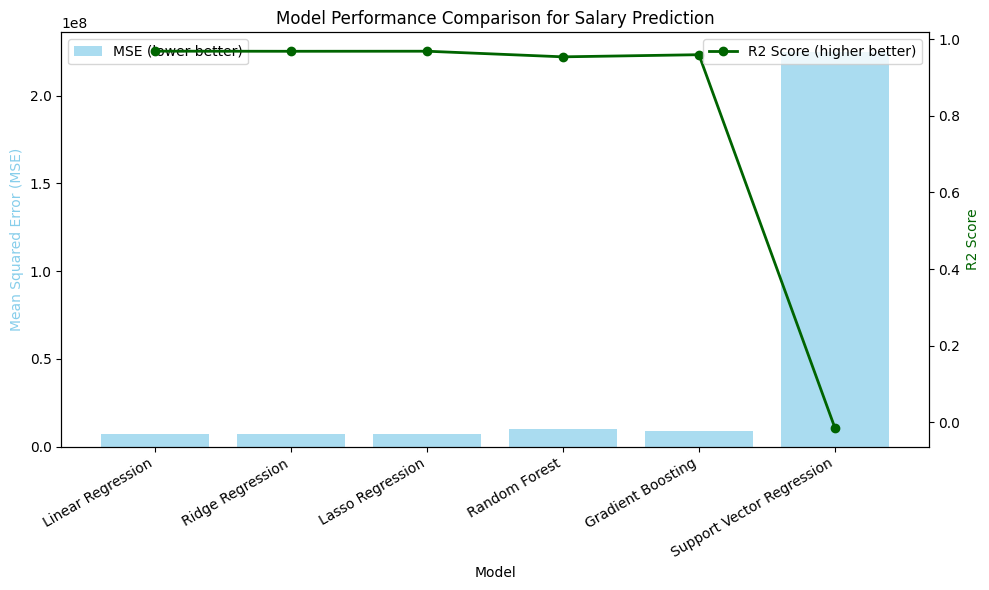

In [2]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('synthetic_salary_data.csv')
X = df.drop('salary', axis=1)
y = df['salary']

cat_cols = ['education', 'occupation']
num_cols = ['age', 'experience', 'hours-per-week']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = {}
for name, model in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}

# Visualize results
methods = list(results.keys())
mse_scores = [results[m]['MSE'] for m in methods]
r2_scores = [results[m]['R2'] for m in methods]

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.bar(methods, mse_scores, color='skyblue', alpha=0.7, label='MSE (lower better)')
ax2.plot(methods, r2_scores, color='darkgreen', marker='o', linestyle='-', linewidth=2, label='R2 Score (higher better)')

ax1.set_xlabel('Model')
ax1.set_ylabel('Mean Squared Error (MSE)', color='skyblue')
ax2.set_ylabel('R2 Score', color='darkgreen')
plt.title('Model Performance Comparison for Salary Prediction')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
fig.autofmt_xdate(rotation=30)
plt.tight_layout()
plt.savefig('model_performance_comparison.png')
plt.show()


Saving the best algo after comapreing algorithms

In [3]:
# saving the best algo after compare
best_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
best_pipe.fit(X, y)  # Train on full data for max accuracy
import joblib
joblib.dump(best_pipe, 'best_salary_model.pkl')
#Linear Regression gave the lowest MSE and highest R², making it the best model for deployment

['best_salary_model.pkl']

Main app

In [4]:
%%writefile streamlit_app.py
import streamlit as st
import pandas as pd
import joblib

# Load model
model = joblib.load("best_salary_model.pkl")

st.title("💼Employee  Salary Predicton  ")
st.write("Enter employee details below for salary prediction, or use batch CSV upload.")

education_levels = ['HS-grad', 'Some-college', 'Assoc', 'Bachelors', 'Masters', 'PhD']
occupation_dict = {
    'HS-grad': ['Sales Associate','Marketing Manager','Graphic Designer'],
    'Some-college': [
        'Tech-support', 'Craft-repair', 'Other-service', 'Handlers-cleaners',
        'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving',
        'Priv-house-serv', 'Protective-serv', 'Armed-Forces'
    ],
    'Assoc': ['Quality Analyst','Plant Supervisor','Nurse'],
    'Bachelors': ['Software Engineer','Business Analyst','Sales Associate'],
    'Masters': ['Data Scientist','Project Manager','Accountant'],
    'PhD': ['Professor','Research Scientist','Legal Advisor']
}

st.sidebar.header("Input Employee Details")
education = st.sidebar.selectbox("Education", education_levels)
occupation_options = occupation_dict.get(education, occupation_dict['HS-grad'])
occupation = st.sidebar.selectbox("Occupation", occupation_options)
age = st.sidebar.slider("Age", 18, 65, 30)
experience = st.sidebar.slider("Years of Experience", 0, 40, 5)
hours_per_week = st.sidebar.slider("Hours per Week", 20, 80, 40)

input_df = pd.DataFrame([{
    'age': age,
    'education': education,
    'occupation': occupation,
    'experience': experience,
    'hours-per-week': hours_per_week
}])

st.write("#### Selected Profile Input")
st.write(input_df)

if st.button("Predict Salary"):
    pred = model.predict(input_df)[0]
    st.success(f"🤑 Predicted Salary: ${int(pred):,}")

# Batch prediction support
st.markdown("---")
st.subheader("Batch Prediction from CSV")
csv_file = st.file_uploader("Upload CSV file", type=["csv"])
if csv_file:
    df = pd.read_csv(csv_file)
    st.write("Preview of Uploaded Data:", df.head())
    preds = model.predict(df)
    df['Predicted_Salary'] = preds.astype(int)
    st.write("Predictions:", df.head())
    csv_pred = df.to_csv(index=False).encode('utf-8')
    st.download_button("Download Predicted CSV", csv_pred, "salary_predictions.csv","text/csv")


Writing streamlit_app.py


In [5]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


In [6]:
!wget -q -O - ipv4.icanhazip.com

34.60.134.166


In [ ]:
! streamlit run streamlit_app.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.60.134.166:8501

⠼⠴⠦⠧⠇⠏⠋your url is: https://modern-hounds-shop.loca.lt
